In [1]:
from ATARI.theory.resonance_statistics import make_res_par_avg
import ATARI.utils.hdf5 as h5io
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import importlib
import os
from copy import copy
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator

from ATARI.Models.particle_pair import Particle_Pair
from ATARI.Models.experimental_model import Experimental_Model

from ATARI.Models.measurement_models.transmission_rpi import Transmission_RPI
from ATARI.Models.measurement_models.capture_yield_rpi import Capture_Yield_RPI
from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT
from ATARI.syndat.control import Syndat_Control


In [2]:
%matplotlib widget

## AutoFit User Example

This notebook gives an examle how the ATARI.AutoFit module can be used to automatically fit data with no need for a prior.

In [3]:
def plot(datasets, experiments, fits=[], priors=[], true=[]):
    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=(8,6), sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color=colors[i], linewidth=0.5, markersize=1.5, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            axes[iax].plot(fits[i].E, fits[i][model_key], color=colors[i], lw=1.5, label=f'fit {exp.title}')
        if len(priors) != 0:
            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color=colors[i], lw=1.5) #, label=f'prior {exp.title}')
        if len(true) != 0:
            axes[iax].plot(true[i].E, true[i]['true'], '-', color=colors[i], alpha=0.5, lw=1.5) #, label=f'prior {exp.title}')

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    ### make it pretty
    for ax in axes:
        # ax.set_xlim([200,250])
        ax.set_ylim([-0.1,1.1])
        ax.legend()

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig

## First, generate data with Syndat to play with

In [4]:
### Reaction Model
Ta_pair = Particle_Pair(isotope = "Ta181",
                        resonance_ladder = pd.DataFrame(),
                        formalism = "XCT",
                        energy_range = [200,250],
                        ac = 8.127,
                        M = 180.94803,
                        I = 3,
                        l_max = 2
)

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D_avg=4.99,
                       Gn_avg=35.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

### Experimental Models
cap1mm_exp_gen = Experimental_Model(title = "cap1",
                                reaction ="capture", 
                                energy_range = [200, 250],
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [270], 
                                    "chw": [102.7],
                                    "dchw": [0.8]
                                }
                               )

trans1mm_exp_gen = Experimental_Model(title = "trans1",
                               reaction = "transmission", 
                               energy_range = [200,250],
                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),
                               channel_widths={
                                    "maxE": [216.16, 613.02], 
                                    "chw": [204.7, 102.4],
                                    "dchw": [1.6, 1.6]
                                }
                               )

sammy_rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": False,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })

template_creator.make_input_template('template_T.inp', Ta_pair, trans1mm_exp_gen, sammy_rto)
template_creator.make_input_template('template_Y.inp', Ta_pair, cap1mm_exp_gen, sammy_rto)


cap1mm_exp_gen.template = os.path.realpath('template_Y.inp')
trans1mm_exp_gen.template = os.path.realpath('template_T.inp')

### Measurement Models
cap1mm_meas_gen = Capture_Yield_RPI()
cap1mm_meas_red = Capture_Yield_RPI()

trans1mm_meas_gen = Transmission_RPI()
trans1mm_meas_red = Transmission_RPI()


### Syndat Models
options_cap1mm = syndatOPT(calculate_covariance=False)

syndat_cap1mm = Syndat_Model(cap1mm_exp_gen,
                            cap1mm_meas_gen,
                            cap1mm_meas_red,
                            options = options_cap1mm,
                            title='cap1mm')

options_trans1mm = syndatOPT(calculate_covariance = True)
syndat_trans1mm = Syndat_Model(trans1mm_exp_gen,
                            trans1mm_meas_gen,
                            trans1mm_meas_red,
                            options = options_trans1mm,
                            title='trans1mm')

In [5]:
### Control module for sampling from multiple syndat models

options_control = syndatOPT()
syndat = Syndat_Control(particle_pair= Ta_pair,
                        syndat_models= [syndat_trans1mm, syndat_cap1mm],
                        model_correlations=None,
                        options=options_control
                        )

syndat.sample(sammy_rto, num_samples=2)

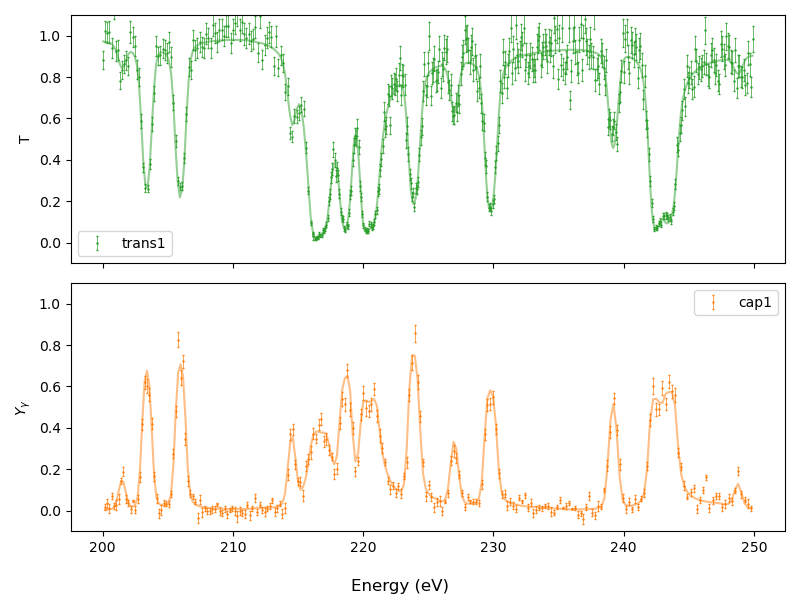

In [6]:
### unpack sample and plot

sample1 = syndat.get_sample(1)

datasets = [sample1['cap1mm'].pw_reduced, sample1['trans1mm'].pw_reduced]#, transdat3, transdat6]
experiments= [cap1mm_exp_gen, trans1mm_exp_gen]#, exptrans3, exptrans6]
covariance_data = [sample1['cap1mm'].covariance_data, sample1['trans1mm'].covariance_data]

fig = plot(datasets, experiments, fits=[], priors=[], true=datasets)
fig.tight_layout()

In [7]:
from ATARI.AutoFit.functions import get_parameter_grid, get_resonance_ladder

num_Elam = 75
Er_1, Gg_1, Gn_1, J_ID_1 = get_parameter_grid([200,250], Ta_pair.spin_groups['3.0'], num_Elam, option=1)
Er_2, Gg_2, Gn_2, J_ID_2 = get_parameter_grid([200,250], Ta_pair.spin_groups['4.0'], num_Elam, option=1)

Er = np.concatenate([Er_1, Er_2])
Gg = np.concatenate([Gg_1, Gg_2])
Gn = np.concatenate([Gn_1, Gn_2])
J_ID = np.concatenate([J_ID_1, J_ID_2])

initial_reslad = get_resonance_ladder(Er, Gg, Gn, J_ID, varyE=0, varyGg=0, varyGn1=1)


sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = initial_reslad,  

    datasets= datasets,
    experiments = experiments,
    experimental_covariance= covariance_data, 
    
    max_steps = 30,
    iterations = 2,
    step_threshold = 0.1,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 1.5,
    LevMarVd = 5,
    initial_parameter_uncertainty = 1.0
    )

sammy_rto_fit = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   True,
                                         "keep_runDIR": True,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })


In [8]:
# sammyOUT_fit = sammy_functions.run_sammy_YW(sammyINPyw, sammy_rto_fit)
from ATARI.AutoFit.initial_FB_solve import InitialFB, InitialFBOPT

options = InitialFBOPT()
autofit_initial = InitialFB(options)

In [9]:
outs = autofit_initial.fit(Ta_pair,
                               [200,250],
                               datasets,
                               experiments,
                               covariance_data,
                               sammy_rto_fit)

	FIT 1
Initial solve from 124 resonance features

Stepping until convergence
chi2 values
step fudge: ['cap1', 'trans1', 'sum']
0    0.5  : [83.9914, 763.501, 847.4924]
1    0.75 : [20.5604, 189.603, 210.1634]
2    1.125: [37.5006, 9.6271, 47.1277]
Repeat step 3, 	fudge: ['cap1', 'trans1', 'sum']
		0.225: [32.6394, 11.4944, 44.1338]
3    0.225: [32.6394, 11.4944, 44.1338]
4    0.338: [16.2596, 10.517, 26.7766]


In [ ]:
final_fb_output = outs[-1]
len(final_fb_output.par_post)


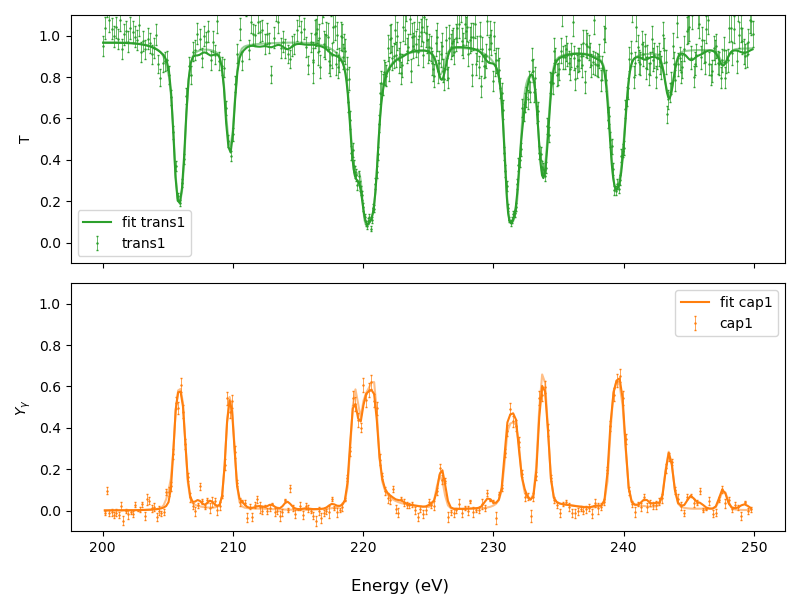

In [ ]:
fig = plot(datasets, experiments, fits=final_fb_output.pw_post, priors=[], true=datasets)
fig.tight_layout()

# AutoFit Module